In [3]:
import numpy as np
import torch
import random
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import copy as cp
from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import torch
import gpytorch
from gpytorch.kernels import Kernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from gpytorch.means import ConstantMean
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

In [4]:
# Set device: Apple/NVIDIA/CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

dtype = torch.float


def batch_tanimoto_sim(
    x1: torch.Tensor, x2: torch.Tensor, eps: float = 1e-6
) -> torch.Tensor:
    """
    Tanimoto similarity between two batched tensors, across last 2 dimensions.
    eps argument ensures numerical stability if all zero tensors are added. Tanimoto similarity is proportional to:

    (<x, y>) / (||x||^2 + ||y||^2 - <x, y>)

    where x and y may be bit or count vectors or in set notation:

    |A \cap B | / |A| + |B| - |A \cap B |

    Args:
        x1: `[b x n x d]` Tensor where b is the batch dimension
        x2: `[b x m x d]` Tensor
        eps: Float for numerical stability. Default value is 1e-6
    Returns:
        Tensor denoting the Tanimoto similarity.
    #from here https://github.com/leojklarner/gauche/blob/main/gauche/kernels/fingerprint_kernels/tanimoto_kernel.py
    """

    if x1.ndim < 2 or x2.ndim < 2:
        raise ValueError("Tensors must have a batch dimension")

    dot_prod = torch.matmul(x1, torch.transpose(x2, -1, -2))
    x1_norm = torch.sum(x1**2, dim=-1, keepdims=True)
    x2_norm = torch.sum(x2**2, dim=-1, keepdims=True)

    tan_similarity = (dot_prod + eps) / (
        eps + x1_norm + torch.transpose(x2_norm, -1, -2) - dot_prod
    )

    return tan_similarity.clamp_min_(
        0
    )  # zero out negative values for numerical stability


class TanimotoKernel(Kernel):
    r"""
     Computes a covariance matrix based on the Tanimoto kernel
     between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:

     .. math::

    \begin{equation*}
     k_{\text{Tanimoto}}(\mathbf{x}, \mathbf{x'}) = \frac{\langle\mathbf{x},
     \mathbf{x'}\rangle}{\left\lVert\mathbf{x}\right\rVert^2 + \left\lVert\mathbf{x'}\right\rVert^2 -
     \langle\mathbf{x}, \mathbf{x'}\rangle}
    \end{equation*}

    .. note::

     This kernel does not have an `outputscale` parameter. To add a scaling parameter,
     decorate this kernel with a :class:`gpytorch.test_kernels.ScaleKernel`.

     Example:
         >>> x = torch.randint(0, 2, (10, 5))
         >>> # Non-batch: Simple option
         >>> covar_module = gpytorch.kernels.ScaleKernel(TanimotoKernel())
         >>> covar = covar_module(x)  # Output: LazyTensor of size (10 x 10)
         >>>
         >>> batch_x = torch.randint(0, 2, (2, 10, 5))
         >>> # Batch: Simple option
         >>> covar_module = gpytorch.kernels.ScaleKernel(TanimotoKernel())
         >>> covar = covar_module(batch_x)  # Output: LazyTensor of size (2 x 10 x 10)
    """

    is_stationary = False
    has_lengthscale = False

    def __init__(self, **kwargs):
        super(TanimotoKernel, self).__init__(**kwargs)

    def forward(self, x1, x2, diag=False, **params):
        if diag:
            assert x1.size() == x2.size() and torch.equal(x1, x2)
            return torch.ones(
                *x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device
            )
        else:
            return self.covar_dist(x1, x2, **params)

    def covar_dist(
        self,
        x1,
        x2,
        last_dim_is_batch=False,
        **params,
    ):
        r"""This is a helper method for computing the bit vector similarity between
        all pairs of points in x1 and x2.

        Args:
            :attr:`x1` (Tensor `n x d` or `b1 x ... x bk x n x d`):
                First set of data.
            :attr:`x2` (Tensor `m x d` or `b1 x ... x bk x m x d`):
                Second set of data.
            :attr:`last_dim_is_batch` (tuple, optional):
                Is the last dimension of the data a batch dimension or not?

        Returns:
            (:class:`Tensor`, :class:`Tensor) corresponding to the distance matrix between `x1` and `x2`.
            The shape depends on the kernel's mode
            * `diag=False`
            * `diag=False` and `last_dim_is_batch=True`: (`b x d x n x n`)
            * `diag=True`
            * `diag=True` and `last_dim_is_batch=True`: (`b x d x n`)
        """
        if last_dim_is_batch:
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        return batch_tanimoto_sim(x1, x2)


def update_model(
    X,
    y,
    bounds_norm,
    kernel_type="Tanimoto",
    fit_y=True,
    FIT_METHOD=True,
    surrogate="GP",
):
    """
    Update and return a Gaussian Process (GP) model with new training data.
    This function configures and optimizes the GP model based on the provided parameters.

    Args:
        X (numpy.ndarray): The training data, typically feature vectors.
        y (numpy.ndarray): The corresponding labels or values for the training data.
        bounds_norm (numpy.ndarray): Normalization bounds for the training data.
        kernel_type (str, optional): Type of kernel to be used in the GP model. Default is "Tanimoto".
        fit_y (bool, optional): Flag to indicate if the output values (y) should be fitted. Default is True.
        FIT_METHOD (bool, optional): Flag to indicate the fitting method to be used. Default is True.
        surrogate (str, optional): Type of surrogate model to be used. Default is "GP".

    Returns:
        model (botorch.models.gpytorch.GP): The updated GP model, fitted with the provided training data.
        scaler_y (TensorStandardScaler): The scaler used for the labels, which can be applied for future data normalization.

    Notes:
        The function initializes a GP model with specified kernel and fitting methods, then fits the model to the provided data.
        The 'bounds_norm' parameter is used for normalizing the training data within the GP model.
        The 'fit_y' and 'FIT_METHOD' parameters control the fitting behavior of the model.
    """

    GP_class = Surrogate_Model(
        kernel_type=kernel_type,
        bounds_norm=bounds_norm,
        fit_y=fit_y,
        FIT_METHOD=FIT_METHOD,
        surrogate=surrogate,
    )
    model = GP_class.fit(X, y)

    return model, GP_class.scaler_y


class TensorStandardScaler:
    """
    StandardScaler for tensors that standardizes features by removing the mean
    and scaling to unit variance, as defined in BoTorch.

    Attributes:
        dim (int): The dimension over which to compute the mean and standard deviation.
        epsilon (float): A small constant to avoid division by zero in case of a zero standard deviation.
        mean (Tensor, optional): The mean value computed in the `fit` method. None until `fit` is called.
        std (Tensor, optional): The standard deviation computed in the `fit` method. None until `fit` is called.

    Args:
        dim (int): The dimension over which to standardize the data. Default is -2.
        epsilon (float): A small constant to avoid division by zero. Default is 1e-9.
    """

    def __init__(self, dim: int = -2, epsilon: float = 1e-9):
        self.dim = dim
        self.epsilon = epsilon
        self.mean = None
        self.std = None

    def fit(self, Y):
        if isinstance(Y, np.ndarray):
            Y = torch.from_numpy(Y).float()
        self.mean = Y.mean(dim=self.dim, keepdim=True)
        self.std = Y.std(dim=self.dim, keepdim=True)
        self.std = self.std.where(
            self.std >= self.epsilon, torch.full_like(self.std, 1.0)
        )

    def transform(self, Y):
        if self.mean is None or self.std is None:
            raise ValueError(
                "Mean and standard deviation not initialized, run `fit` method first."
            )
        original_type = None
        if isinstance(Y, np.ndarray):
            original_type = np.ndarray
            Y = torch.from_numpy(Y).float()
        Y_transformed = (Y - self.mean) / self.std
        if original_type is np.ndarray:
            return Y_transformed.numpy()
        else:
            return Y_transformed

    def fit_transform(self, Y):
        self.fit(Y)
        return self.transform(Y)

    def inverse_transform(self, Y):
        if self.mean is None or self.std is None:
            raise ValueError(
                "Mean and standard deviation not initialized, run `fit` method first."
            )
        original_type = None
        if isinstance(Y, np.ndarray):
            original_type = np.ndarray
            Y = torch.from_numpy(Y).float()
        Y_inv_transformed = (Y * self.std) + self.mean
        if original_type is np.ndarray:
            return Y_inv_transformed.numpy()
        else:
            return Y_inv_transformed


class Surrogate_Model:

    def __init__(
        self,
        kernel_type="Tanimoto",
        bounds_norm=None,
        fit_y=True,
        FIT_METHOD=True,
        surrogate="GP",
    ):
        self.kernel_type = kernel_type
        self.bounds_norm = bounds_norm
        self.fit_y = fit_y
        self.surrogate = surrogate
        self.FIT_METHOD = FIT_METHOD
        self.scaler_y = TensorStandardScaler()

    def fit(self, X_train, y_train):
        if type(X_train) == np.ndarray:
            X_train = torch.tensor(X_train, dtype=torch.float32)

        if self.fit_y:
            y_train = self.scaler_y.fit_transform(y_train)
        else:
            y_train = y_train

        self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
        self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)

        """
        Use BoTorch fit method
        to fit the hyperparameters of the GP and the model weights
        """

        self.kernel_type == "Tanimoto"
        kernel = TanimotoKernel()

        class InternalGP(SingleTaskGP):
            def __init__(self, train_X, train_Y, kernel):
                super().__init__(train_X, train_Y)
                self.mean_module = ConstantMean()
                self.covar_module = ScaleKernel(kernel)

        self.gp = InternalGP(self.X_train_tensor, self.y_train_tensor, kernel)

        self.gp.likelihood.noise_constraint = gpytorch.constraints.GreaterThan(
                1e-3
            )

        self.mll = ExactMarginalLogLikelihood(self.gp.likelihood, self.gp)
        self.mll.to(self.X_train_tensor)

        fit_gpytorch_model(self.mll, max_retries=50000)


        self.gp.eval()
        self.mll.eval()

        return self.gp

In [5]:
random.seed(777)
np.random.seed(777)

def inchi_to_smiles(inchi_list):
    """
    Convert a list of InChI strings to a list of canonical SMILES strings.

    Args:
    inchi_list (list): A list of InChI strings.

    Returns:
    list: A list of canonical SMILES strings.
    """
    smiles_list = []
    for inchi in inchi_list:
        mol = Chem.MolFromInchi(inchi)
        if mol:
            smiles = Chem.MolToSmiles(mol)
            smiles_list.append(smiles)
        else:
            smiles_list.append(None)  # Append None for invalid InChI strings
    return smiles_list


class FingerprintGenerator:
    def __init__(self, nBits=512, radius=2):
        self.nBits = nBits
        self.radius = radius

    def featurize(self, smiles_list):
        fingerprints = []
        for smiles in smiles_list:
            if not isinstance(smiles, str):
                fingerprints.append(np.ones(self.nBits))
            else:
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    fp = AllChem.GetMorganFingerprintAsBitVect(
                        mol, self.radius, nBits=self.nBits
                    )
                    fp_array = np.array(
                        list(fp.ToBitString()), dtype=int
                    )  # Convert to NumPy array
                    fingerprints.append(fp_array)
                else:
                    print(f"Could not generate a molecule from SMILES: {smiles}")
                    fingerprints.append(np.array([None]))

        return np.array(fingerprints)



def convert2pytorch(X, y):
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float().reshape(-1, 1)
    return X, y


def check_entries(array_of_arrays):
    """
    Check if the entries of the arrays are between 0 and 1.
    Needed for for the datasets.py script.
    """

    for array in array_of_arrays:
        for item in array:
            if item < 0 or item > 1:
                return False
    return True


class directaryl:
    def __init__(self):
        # direct arylation reaction
        self.ECFP_size = 512
        self.radius = 2
        self.ftzr = FingerprintGenerator(nBits=self.ECFP_size, radius=self.radius)
        dataset_url = "https://raw.githubusercontent.com/doyle-lab-ucla/edboplus/main/examples/publication/BMS_yield_cost/data/PCI_PMI_cost_full.csv"
        self.data = pd.read_csv(dataset_url)
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        # create a copy of the data
        data_copy = self.data.copy()
        # remove the Yield column from the copy
        data_copy.drop("Yield", axis=1, inplace=True)
        # check for duplicates
        duplicates = data_copy.duplicated().any()
        if duplicates:
            print("There are duplicates in the dataset.")
            exit()

        self.data["Base_SMILES"] = inchi_to_smiles(self.data["Base_inchi"].values)
        self.data["Ligand_SMILES"] = inchi_to_smiles(self.data["Ligand_inchi"].values)
        self.data["Solvent_SMILES"] = inchi_to_smiles(self.data["Solvent_inchi"].values)
        col_0_base = self.ftzr.featurize(self.data["Base_SMILES"])
        col_1_ligand = self.ftzr.featurize(self.data["Ligand_SMILES"])
        col_2_solvent = self.ftzr.featurize(self.data["Solvent_SMILES"])
        col_3_concentration = self.data["Concentration"].to_numpy().reshape(-1, 1)
        col_4_temperature = self.data["Temp_C"].to_numpy().reshape(-1, 1)
        self.X = np.concatenate(
            [
                col_0_base,
                col_1_ligand,
                col_2_solvent,
                col_3_concentration,
                col_4_temperature,
            ],
            axis=1,
        )
        self.experiments = np.concatenate(
            [
                self.data["Base_SMILES"].to_numpy().reshape(-1, 1),
                self.data["Ligand_SMILES"].to_numpy().reshape(-1, 1),
                self.data["Solvent_SMILES"].to_numpy().reshape(-1, 1),
                self.data["Concentration"].to_numpy().reshape(-1, 1),
                self.data["Temp_C"].to_numpy().reshape(-1, 1),
                self.data["Yield"].to_numpy().reshape(-1, 1),
            ],
            axis=1,
        )

        self.y = self.data["Yield"].to_numpy()
        self.all_ligands = self.data["Ligand_SMILES"].to_numpy()
        self.all_bases = self.data["Base_SMILES"].to_numpy()
        self.all_solvents = self.data["Solvent_SMILES"].to_numpy()
        unique_bases = np.unique(self.data["Base_SMILES"])
        unique_ligands = np.unique(self.data["Ligand_SMILES"])
        unique_solvents = np.unique(self.data["Solvent_SMILES"])
        unique_concentrations = np.unique(self.data["Concentration"])
        unique_temperatures = np.unique(self.data["Temp_C"])

        max_yield_per_ligand = np.array(
            [
                max(self.data[self.data["Ligand_SMILES"] == unique_ligand]["Yield"])
                for unique_ligand in unique_ligands
            ]
        )

        self.worst_ligand = unique_ligands[np.argmin(max_yield_per_ligand)]
        self.best_ligand = unique_ligands[np.argmax(max_yield_per_ligand)]

        self.where_worst_ligand = np.array(
            self.data.index[self.data["Ligand_SMILES"] == self.worst_ligand].tolist()
        )

        self.feauture_labels = {
            "names": {
                "bases": unique_bases,
                "ligands": unique_ligands,
                "solvents": unique_solvents,
                "concentrations": unique_concentrations,
                "temperatures": unique_temperatures,
            },
            "ordered_smiles": {
                "bases": self.data["Base_SMILES"],
                "ligands": self.data["Ligand_SMILES"],
                "solvents": self.data["Solvent_SMILES"],
                "concentrations": self.data["Concentration"],
                "temperatures": self.data["Temp_C"],
            },
        }


class Evaluation_data:
    def __init__(
        self
    ):
        self.get_raw_dataset()

        rep_size = self.X.shape[1]
        self.bounds_norm = torch.tensor([[0] * rep_size, [1] * rep_size])
        self.bounds_norm = self.bounds_norm.to(dtype=torch.float32)

        if not check_entries(self.X):
            print("###############################################")
            print(
                "Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline."
            )
            print("###############################################")

            self.scaler_X = MinMaxScaler()
            self.X = self.scaler_X.fit_transform(self.X)

    def get_raw_dataset(self):
        # https://github.com/doyle-lab-ucla/edboplus/blob/main/examples/publication/BMS_yield_cost/data/PCI_PMI_cost_full_update.csv

        BMS = directaryl()
        self.data = BMS.data
        self.experiments = BMS.experiments
        self.X, self.y = BMS.X, BMS.y

        self.all_ligands = BMS.all_ligands
        self.all_bases = BMS.all_bases
        self.all_solvents = BMS.all_solvents

        self.best_ligand = BMS.best_ligand
        self.worst_ligand = BMS.worst_ligand
        self.where_worst_ligand = BMS.where_worst_ligand
        self.feauture_labels = BMS.feauture_labels


    def get_init_holdout_data(self, SEED):
        random.seed(SEED)
        torch.manual_seed(SEED)
        np.random.seed(SEED)

        indices_init = self.where_worst_ligand[:200]
        exp_init = self.experiments[indices_init]
        indices_holdout = np.setdiff1d(np.arange(len(self.y)), indices_init)

        np.random.shuffle(indices_init)
        np.random.shuffle(indices_holdout)

        X_init, y_init = self.X[indices_init], self.y[indices_init]
        X_holdout, y_holdout = self.X[indices_holdout], self.y[indices_holdout]
        exp_holdout = self.experiments[indices_holdout]

        LIGANDS_INIT = self.all_ligands[indices_init]
        LIGANDS_HOLDOUT = self.all_ligands[indices_holdout]

        X_init, y_init = convert2pytorch(X_init, y_init)
        X_holdout, y_holdout = convert2pytorch(X_holdout, y_holdout)

        return (
            X_init,
            y_init,
            X_holdout,
            y_holdout,
            LIGANDS_INIT,
            LIGANDS_HOLDOUT,
            exp_init,
            exp_holdout,
        )

DATASET = Evaluation_data()
bounds_norm = DATASET.bounds_norm

(
    X_init,
    y_init,
    X_pool_fixed,
    y_pool_fixed,
    LIGANDS_INIT,
    LIGANDS_HOLDOUT,
    exp_init,
    exp_holdout,
) = DATASET.get_init_holdout_data(777)

###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


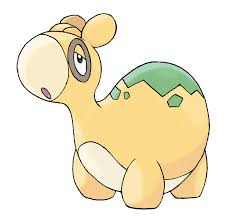

In [6]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.optim import optimize_acqf_discrete
from botorch.sampling import SobolQMCNormalSampler

NUM_RESTARTS = 20
RAW_SAMPLES = 512
sampler = SobolQMCNormalSampler(1024)


In [7]:
def find_indices(X_candidate_BO, candidates):
    """
    Identifies and returns the indices of specific candidates within a larger dataset.
    This function is particularly useful when the order of candidates returned by an
    acquisition function differs from the original dataset order.

    Args:
        X_candidate_BO (numpy.ndarray): The complete dataset or holdout set,
            typically consisting of feature vectors.
        candidates (numpy.ndarray): A subset of the dataset (e.g., a batch of
            molecules) selected by the acquisition function.

    Returns:
        numpy.ndarray: An array of indices corresponding to the positions of
            each candidate in the original dataset 'X_candidate_BO'.
    """

    indices = []
    for candidate in candidates:
        indices.append(np.argwhere((X_candidate_BO == candidate).all(1)).flatten()[0])
    indices = np.array(indices)
    return indices

The main BO loop for fixed `q` and helper functions


In [8]:

def bo_inner(model, sampler, bounds_norm, q, 
             X_train, y_train, X_pool, y_pool, 
             yield_thr=99.0):    
            
    # Set up aqf
    qNEI = qNoisyExpectedImprovement(model, torch.tensor(X_train), sampler)
    X_candidate, _ = optimize_acqf_discrete(
      acq_function=qNEI,
      bounds=bounds_norm,
      q=q,
      choices=torch.tensor(X_pool),
      unique=True,
      num_restarts=NUM_RESTARTS,
      raw_samples=RAW_SAMPLES,
      sequential=False,
    )

    # See how they actually look
    X_candidate = np.array(X_candidate)
    indices = find_indices(X_pool, X_candidate)
    indices_keep = np.setdiff1d(np.arange(X_pool.shape[0]), indices)
    y_candidate = y_pool[indices]

    # We also count the number of experiments conducted
    n_experiments = y_candidate.shape[0]

    # Remove from pool
    X_pool = X_pool[indices_keep]
    y_pool = y_pool[indices_keep]

    # If we got good performance, we are done
    success = any(y_candidate > yield_thr)

    if success:
      print("We found some good candidate! :)")
    else:
      print(f"The best we could do in this selected batch was {max(y_candidate)}! :(")
      X_train = np.vstack([X_train, X_candidate])
      y_train = np.concatenate([y_train, y_candidate])
      model, _ = update_model(X_train, y_train, bounds_norm, kernel_type="Tanimoto", fit_y=False, FIT_METHOD=True)

    print(y_candidate)
    return success, n_experiments, model, X_train, y_train, X_pool, y_pool

 
def init_stuff(seed):
  # Initialize data from dataset
  DATASET = Evaluation_data()
  bounds_norm = DATASET.bounds_norm

  (
      X_init,
      y_init,
      X_pool_fixed,
      y_pool_fixed,
      _,
      _,
      _,
      _,
  ) = DATASET.get_init_holdout_data(seed)

  # Construct initial shitty model
  model, _ = update_model(
      X_init, y_init, bounds_norm, kernel_type="Tanimoto", fit_y=False, FIT_METHOD=True
  )

  # Copy things to avoid problems later
  X_train = np.copy(X_init)
  y_train = np.copy(y_init)
  X_pool = np.copy(X_pool_fixed)
  y_pool = np.copy(y_pool_fixed)
  
  return model, X_train, y_train, X_pool, y_pool 


def bo_above(q, seed, max_iterations=100):

  model, X_train, y_train, X_pool, y_pool = init_stuff(seed)

  # Count experiments
  n_experiments = 0

  # Count iterations
  n_iter = 0

  for i in range(max_iterations):
    is_found, n_experiments_incr, model, X_train, y_train, X_pool, y_pool = bo_inner(model, sampler, bounds_norm, q, X_train, y_train, X_pool, y_pool)
    n_experiments += n_experiments_incr
    n_iter += 1
    if is_found is True:
      break

  return n_experiments, n_iter

The old BO loop to check we don't screw up (and "tests")


In [9]:
def bo_above_old(q, seed, max_iterations=100):

  # Initialize data from dataset
  DATASET = Evaluation_data()
  bounds_norm = DATASET.bounds_norm

  (
      X_init,
      y_init,
      X_pool_fixed,
      y_pool_fixed,
      _,
      _,
      _,
      _,
  ) = DATASET.get_init_holdout_data(seed)

  # Construct initial shitty model
  model, _ = update_model(
      X_init, y_init, bounds_norm, kernel_type="Tanimoto", fit_y=False, FIT_METHOD=True
  )

  # Copy things to avoid problems later
  X_train = np.copy(X_init)
  y_train = np.copy(y_init)
  X_pool = np.copy(X_pool_fixed)
  y_pool = np.copy(y_pool_fixed)

  # Start a timer
  fixed_time = 1
  overhead_factor = 0.5
  overhead_time = overhead_factor * fixed_time
  training_time = 2
  total_time = 0

  # Count experiments
  n_experiments = 0

  # Count iterations
  n_iter = 0

  for _ in range(max_iterations):

    # Add fixed time
    total_time += fixed_time

    # Select batch size, for now dummy passed
    # Here is where the fun begins! Including the calls below

    # Set up aqf
    qNEI = qNoisyExpectedImprovement(model, torch.tensor(X_train), sampler)
    X_candidate, _ = optimize_acqf_discrete(
      acq_function=qNEI,
      bounds=bounds_norm,
      q=q,
      choices=torch.tensor(X_pool),
      unique=True,
      num_restarts=NUM_RESTARTS,
      raw_samples=RAW_SAMPLES,
      sequential=False,
    )

    # See how selected experiments look at the moment
    y_pred = model.posterior(X_candidate).mean.detach().flatten().numpy()
    y_std = np.sqrt(model.posterior(X_candidate).variance.detach().flatten().numpy())

    # See how they actually look
    X_candidate = np.array(X_candidate)
    indices = find_indices(X_pool, X_candidate)
    indices_keep = np.setdiff1d(np.arange(X_pool.shape[0]), indices)
    y_candidate = y_pool[indices]

    # We have sampled the candidates, so we pay the overhead time n-1 times
    total_time += overhead_time*(y_candidate.shape[0] -1)

    # We also count the number of experiments conducted
    n_experiments += y_candidate.shape[0]
    n_iter += 1

    # Remove from pool
    X_pool = X_pool[indices_keep]
    y_pool = y_pool[indices_keep]

    # If we got good performance, we are done
    if any(y_candidate > 99.0 ): # :)
      print("We found some good candidate! :)")
      print(y_candidate)
      break
    else:
      print(f"The best we could do in this selected batch was {max(y_candidate)}! :(")
      print(y_candidate)

    # If not, sample points and retrain
    X_train = np.vstack([X_train, X_candidate])
    y_train = np.concatenate([y_train, y_candidate])
    model, _ = update_model(X_train, y_train, bounds_norm, kernel_type="Tanimoto", fit_y=False, FIT_METHOD=True)

    # And also add the time it takes to train, which can be important
    total_time += training_time

  print(f"The total time for the optimization was {total_time} for a total of {n_experiments} experiments!")
  return n_experiments, n_iter

In [10]:

bo_above_old(q=3, seed=666, max_iterations=5) 

###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]
The total time for the optimization was 20.0 for a total of 15 experiments!


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


(15, 5)

In [11]:

bo_above(q=3, seed=666, max_iterations=5) 

###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


(15, 5)

Get baseline results with fixed `q`

In [13]:
max_batch_size = 10  # 10
n_seeds = 10         # 10
max_iterations = 100  # 100

q_arr = range(2, max_batch_size+1)

timings_all = np.zeros((n_seeds, len(q_arr), 2))
for seed in range(n_seeds):
  timings_all[seed] = [bo_above(q=q, seed=seed, max_iterations=max_iterations) for q in q_arr]
  

###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]
 [92.03]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.8525], dtype=torch.float64), std = tensor([13.8171], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [66.84]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9441], dtype=torch.float64), std = tensor([13.8175], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [66.84]
 [16.77]
 [81.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4574], dtype=torch.float64), std = tensor([15.1651], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [30.41]
 [57.85]
 [ 5.48]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [66.84]
 [16.77]
 [81.48]
 [88.41]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0090], dtype=torch.float64), std = tensor([16.5933], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [ 1.68]
 [52.77]
 [28.9 ]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]
 [92.03]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.5209], dtype=torch.float64), std = tensor([12.8373], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9441], dtype=torch.float64), std = tensor([13.8175], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [88.41]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.5027], dtype=torch.float64), std = tensor([15.4080], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [81.48]
 [52.77]
 [28.9 ]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [88.41]
 [81.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0090], dtype=torch.float64), std = tensor([16.5933], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [ 1.68]
 [30.41]
 [52.77]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]
 [92.03]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [26.78]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.5872], dtype=torch.float64), std = tensor([12.9369], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [26.78]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0099], dtype=torch.float64), std = tensor([13.9074], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [26.78]
 [66.84]
 [81.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.5228], dtype=torch.float64), std = tensor([15.2443], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [30.41]
 [57.85]
 [ 5.48]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [26.78]
 [66.84]
 [81.48]
 [84.81]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0506], dtype=torch.float64), std = tensor([16.5461], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [ 1.68]
 [30.41]
 [53.43]
 [28.9 ]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]
 [92.03]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.5209], dtype=torch.float64), std = tensor([12.8373], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9441], dtype=torch.float64), std = tensor([13.8175], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [81.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4574], dtype=torch.float64), std = tensor([15.1651], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [30.41]
 [57.85]
 [ 5.48]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [81.48]
 [88.41]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0090], dtype=torch.float64), std = tensor([16.5933], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [ 1.68]
 [30.41]
 [52.77]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [92.03]
 [50.74]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.5209], dtype=torch.float64), std = tensor([12.8373], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9441], dtype=torch.float64), std = tensor([13.8175], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [81.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4574], dtype=torch.float64), std = tensor([15.1651], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [30.41]
 [57.85]
 [ 5.48]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [81.48]
 [88.41]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0090], dtype=torch.float64), std = tensor([16.5933], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [ 1.68]
 [30.41]
 [52.77]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [92.03]
 [50.74]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.5209], dtype=torch.float64), std = tensor([12.8373], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9441], dtype=torch.float64), std = tensor([13.8175], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [88.41]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.5027], dtype=torch.float64), std = tensor([15.4080], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [81.48]
 [30.41]
 [52.77]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [88.41]
 [81.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0090], dtype=torch.float64), std = tensor([16.5933], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [ 1.68]
 [30.41]
 [52.77]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]
The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[[81.48]
 [95.48]
 [16.77]
 [66.84]]
We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]
 [92.03]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.5209], dtype=torch.float64), std = tensor([12.8373], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9441], dtype=torch.float64), std = tensor([13.8175], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [88.41]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.5027], dtype=torch.float64), std = tensor([15.4080], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [81.48]
 [30.41]
 [52.77]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [88.41]
 [39.57]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.7369], dtype=torch.float64), std = tensor([15.6302], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [30.41]
 [52.77]
 [50.74]
 [72.9 ]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]
 [92.03]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.5209], dtype=torch.float64), std = tensor([12.8373], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9441], dtype=torch.float64), std = tensor([13.8175], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [81.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4574], dtype=torch.float64), std = tensor([15.1651], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [30.41]
 [57.85]
 [ 5.48]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [81.48]
 [84.81]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.9856], dtype=torch.float64), std = tensor([16.4758], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [99.22]
 [38.8 ]
 [59.82]
 [92.03]
 [30.41]
 [53.43]
 [50.74]
 [ 1.68]
 [62.75]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [92.03]
 [50.74]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [26.78]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.5872], dtype=torch.float64), std = tensor([12.9369], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [26.78]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0099], dtype=torch.float64), std = tensor([13.9074], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [26.78]
 [66.84]
 [67.63]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4323], dtype=torch.float64), std = tensor([14.8133], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [50.74]
 [98.38]
 [43.84]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [26.78]
 [66.84]
 [67.63]
 [88.41]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.9841], dtype=torch.float64), std = tensor([16.2755], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [30.41]
 [52.77]
 [72.21]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0451], dtype=torch.float64), std = tensor([7.7341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9307], dtype=torch.float64), std = tensor([11.0682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [78.6]! :(
[[78.6 ]
 [36.96]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.6754], dtype=torch.float64), std = tensor([12.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [35.61]! :(
[[35.61]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9516], dtype=torch.float64), std = tensor([13.1686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.0623], dtype=torch.float64), std = tensor([16.3146], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [92.03]! :(
[[ 1.68]
 [92.03]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6110], dtype=torch.float64), std = tensor([17.6745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2802], dtype=torch.float64), std = tensor([8.2179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4988], dtype=torch.float64), std = tensor([12.0817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [81.48]! :(
[[78.6 ]
 [81.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.6057], dtype=torch.float64), std = tensor([14.9109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [23.23]! :(
[[ 6.44]
 [23.23]
 [11.72]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.8017], dtype=torch.float64), std = tensor([14.8645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[22.07]
 [66.84]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.8896], dtype=torch.float64), std = tensor([17.2054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [38.65]
 [88.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8026], dtype=torch.float64), std = tensor([10.3667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [53.46]
 [16.85]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0939], dtype=torch.float64), std = tensor([13.5424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[81.48]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.6849], dtype=torch.float64), std = tensor([17.2698], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[92.03]
 [99.22]
 [50.74]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [89.71]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8014], dtype=torch.float64), std = tensor([10.3316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [87.32]! :(
[[87.32]
 [45.85]
 [36.96]
 [16.85]
 [78.19]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4648], dtype=torch.float64), std = tensor([14.4447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


The best we could do in this selected batch was [95.48]! :(
[[50.7 ]
 [16.77]
 [95.48]
 [81.48]
 [ 1.68]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([4.9037], dtype=torch.float64), std = tensor([17.5309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[99.22]
 [50.74]
 [92.03]
 [59.82]
 [23.23]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.4259], dtype=torch.float64), std = tensor([12.8270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.5209], dtype=torch.float64), std = tensor([12.8373], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9441], dtype=torch.float64), std = tensor([13.8175], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [92.03]
 [59.82]
 [30.41]
 [67.85]
 [98.38]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [88.41]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.5027], dtype=torch.float64), std = tensor([15.4080], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [81.48]
 [52.77]
 [28.9 ]]
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train_tensor = torch.tensor(y_train, dtype=torch.float64).view(-1, 1)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3105], dtype=torch.float64), std = tensor([1.7566], dtype=torch.float64)). Please consider scaling the input to zero mean a

The best we could do in this selected batch was [95.48]! :(
[[89.71]
 [18.16]
 [35.61]
 [78.6 ]
 [ 1.62]
 [95.48]
 [16.77]
 [66.84]
 [88.41]
 [67.63]]


/var/folders/2p/_48gkvjx1wn0sc3d9_823byc0000gn/T/ipykernel_78727/2981832511.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/Users/yannick/anaconda3/envs/bohack/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.9191], dtype=torch.float64), std = tensor([16.2037], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


We found some good candidate! :)
[[96.64]
 [38.8 ]
 [99.22]
 [59.82]
 [92.03]
 [53.43]
 [52.77]
 [50.74]
 [30.41]
 [62.75]]


In [14]:
np.save('basline_timings_flow.npy', timings_all)

In [15]:
timings_all

array([[[14.,  7.],
        [18.,  6.],
        [16.,  4.],
        [20.,  4.],
        [12.,  2.],
        [14.,  2.],
        [16.,  2.],
        [18.,  2.],
        [20.,  2.]],

       [[14.,  7.],
        [18.,  6.],
        [16.,  4.],
        [20.,  4.],
        [12.,  2.],
        [14.,  2.],
        [16.,  2.],
        [18.,  2.],
        [20.,  2.]],

       [[14.,  7.],
        [18.,  6.],
        [16.,  4.],
        [20.,  4.],
        [12.,  2.],
        [14.,  2.],
        [16.,  2.],
        [18.,  2.],
        [20.,  2.]],

       [[14.,  7.],
        [18.,  6.],
        [16.,  4.],
        [20.,  4.],
        [12.,  2.],
        [14.,  2.],
        [16.,  2.],
        [18.,  2.],
        [20.,  2.]],

       [[14.,  7.],
        [18.,  6.],
        [16.,  4.],
        [20.,  4.],
        [12.,  2.],
        [14.,  2.],
        [16.,  2.],
        [18.,  2.],
        [20.,  2.]],

       [[14.,  7.],
        [18.,  6.],
        [16.,  4.],
        [20.,  4.],
        [1

In [16]:
timings_all_mean = timings_all.mean(axis=0)
timings_exps = timings_all_mean

Plots


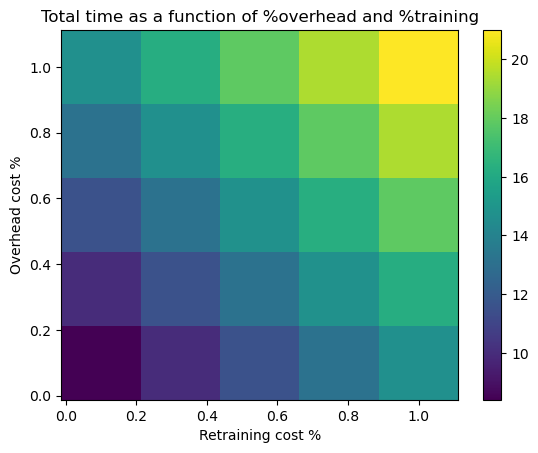

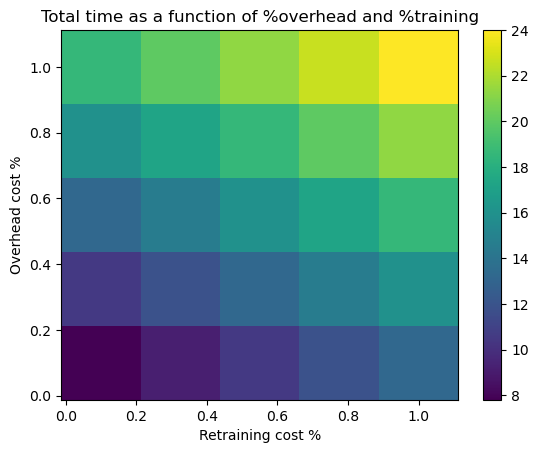

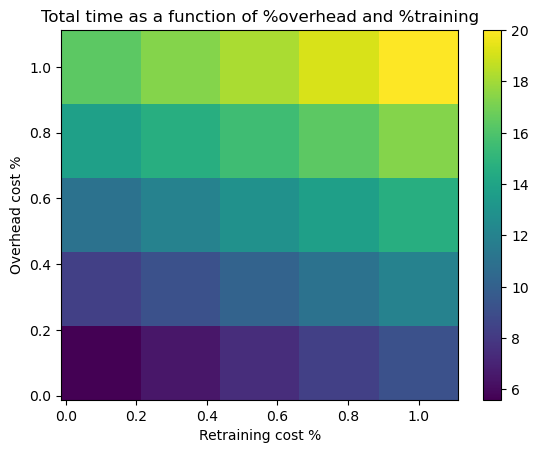

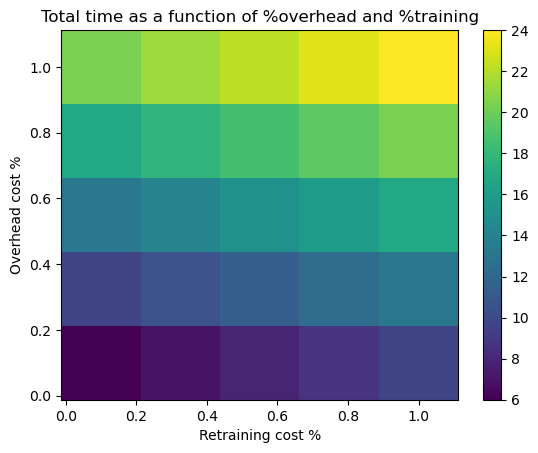

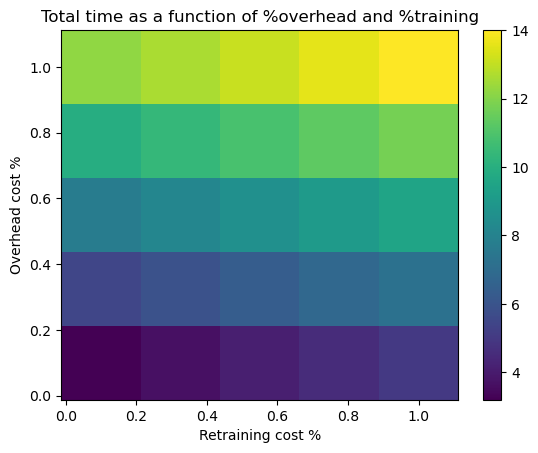

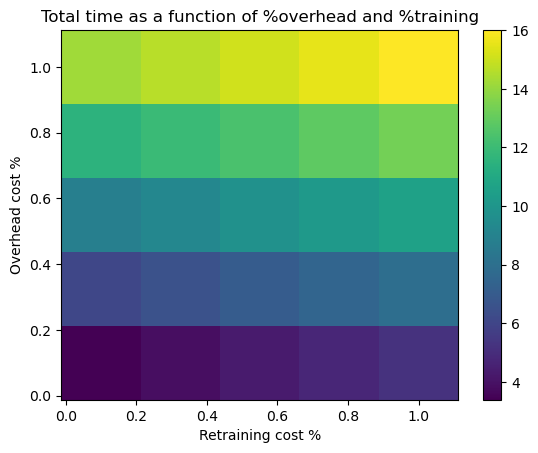

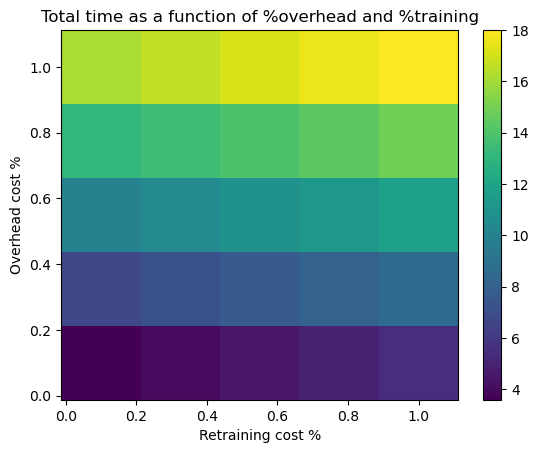

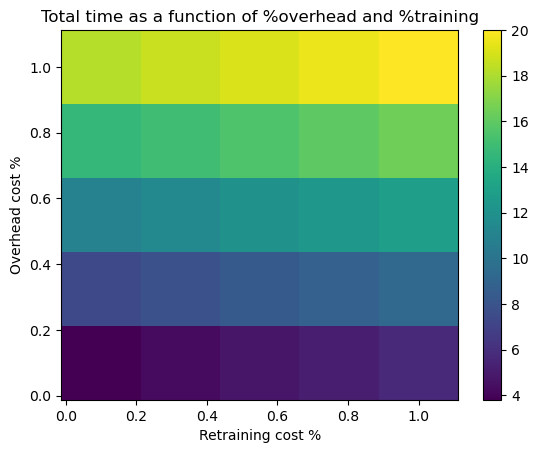

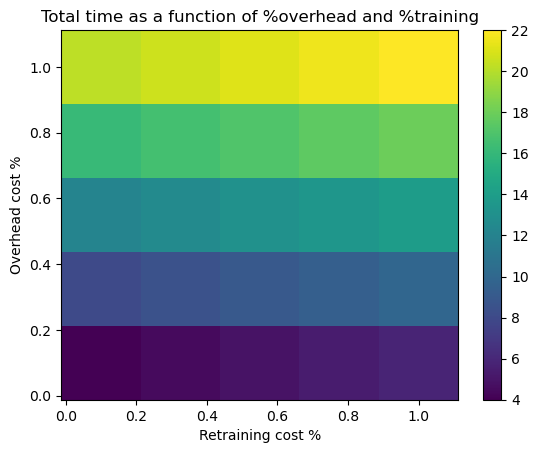

In [17]:
rt_arr = np.linspace(0.1,1.0,5) # time of retraining as % of experiment baseline time
ot_arr = np.linspace(0.1,1.0,5) # overhead time per experiment as % of experiment baseline time

def compute_cost(rt, ot, n_exp, n_iter):
  total_cost = 0.0
  total_cost += n_iter  # Baseline experiment cost (per iteration)
  total_cost += rt * n_iter # Retraining cost (per iteration)
  total_cost += (n_exp - n_iter) * ot # Sum of the overheads
  return total_cost

for n_exp, n_iter in timings_exps :
  x, y = np.meshgrid(rt_arr, ot_arr)
  tt_arr = compute_cost(x, y, n_exp, n_iter)
  plt.xlabel("Retraining cost %")
  plt.ylabel("Overhead cost %")
  plt.pcolormesh(rt_arr, ot_arr, tt_arr)
  plt.title('Total time as a function of %overhead and %training')
  plt.colorbar()
  plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


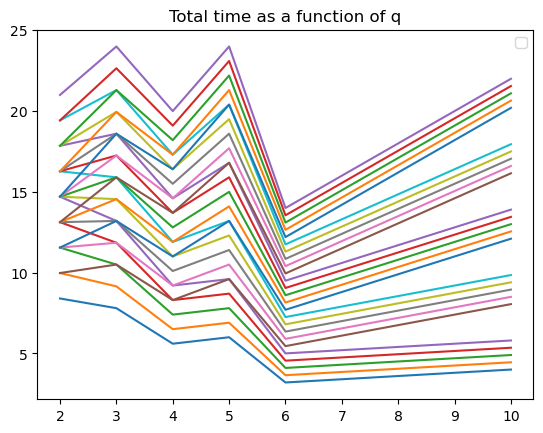

In [18]:
z = np.zeros((len(q_arr),25))
x, y = np.meshgrid(rt_arr, ot_arr)
for i, (n_exp, n_iter) in enumerate(timings_exps) :
  p = q_arr
  z[i,:] = compute_cost(x,y,n_exp,n_iter).flatten()
plt.plot(p,z)
plt.title('Total time as a function of q')
plt.legend()
plt.show()


BO loop but with `q` depending on iteration number

In [ ]:

def bo_above_flex_batch(q_arr, seed, max_iterations=100):

  model, X_train, y_train, X_pool, y_pool = init_stuff(seed)

  # Count experiments
  n_experiments = 0
  
  for i in range(max_iterations):
    q = q_arr[i] if i<len(q_arr) else q_arr[-1]
    is_found, n_experiments_incr, model, X_train, y_train, X_pool, y_pool = bo_inner(model, sampler, bounds_norm, q, X_train, y_train, X_pool, y_pool)
    n_experiments += n_experiments_incr
    if is_found is True:
      break

  return n_experiments, i+1

Try different ways to change `q` 

In [ ]:

# q_arr = np.arange(10,1,-2)
# q_arr = np.arange(7,1,-1)
q_arr = np.arange(5,1,-1)

n_seeds = 10         # 10
max_iterations = 100  # 100

timings_all = np.zeros((n_seeds, 2))
for seed in range(n_seeds):
  timings_all[seed] = bo_above_flex_batch(q_arr, seed=seed, max_iterations=max_iterations)

print(timings_all)